In [243]:
import maboss
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import shutil



In [ ]:
def get_phenotype(prob, eps = 0.25): 
    A = prob["RhoA"]
    C = prob["RhoC"]
    delta = C - A

    # Binary classification
    hyper   = (delta > eps).astype(float)
    failed  = (delta < -eps).astype(float)
    normal  = ((abs(delta) <= eps)).astype(float)

    pheno_df = pd.DataFrame({
            "Failed": failed,
            "Hyper": hyper,
            "Normal": normal
    }, index=prob.index)

    return pheno_df

def save_sim_details(outdir, res, name):
    # Save node probabilities
    nodes = res.get_nodes_probtraj().rename_axis('t').reset_index()
    nodes.to_csv(os.path.join(outdir, f"{name}_nodes_probtraj.csv"), index=False)

    # Save state probabilities
    states = res.get_states_probtraj().rename_axis('t').reset_index()
    states.to_csv(os.path.join(outdir, f"{name}_states_probtraj.csv"), index=False)

    # Save the full simulation object
    res.save(os.path.join(outdir, f"{name}_simulation"))


In [341]:
def plot_rhos(name, df, save=False, outdir=None):
    fig, ax = plt.subplots(figsize=(6,4))

    df['RhoA'].plot(ax=ax, label='RhoA')
    df['RhoC'].plot(ax=ax, label='RhoC')

    ax.set_title(f"{name} – RhoA / RhoC activation probabilities")
    ax.set_xlabel('Time')
    ax.set_ylabel('Probability')
    ax.legend()

    plt.tight_layout()

    if save and outdir is not None:
        fname = f"{name}_rhoa_rhoc.png".replace(" ", "_")
        fig.savefig(os.path.join(outdir, fname), dpi=300)

    plt.close(fig)
    return fig
    #plt.show()

    return fig

def plot_delta(name, df, eps, save=False, outdir=None):
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(df.index, df["delta"], label="Δ(t)")

    ax.axhline(eps, linestyle="--", label="+ε", color='red')
    ax.axhline(-eps, linestyle="--", label="-ε", color='red')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_ylim(-0.5, 0.5)
    ax.set_title(f"{name} – Rho balance")
    ax.set_xlabel("Time")
    ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
    ax.legend()

    plt.tight_layout()

    if save and outdir is not None:
        fname = f"{name}_delta.png".replace(" ", "_")
        fig.savefig(os.path.join(outdir, fname), dpi=300)

    plt.close(fig)
    return fig
    #plt.show()

In [339]:
""" SETUP """
# Setup MaBoSS model
model_file = "../maboss/models/model_two.bnd"
cfg_file = "../maboss/models/model_two_base.cfg"
model = maboss.load(model_file, cfg_file) # WT
eps = 0.25



In [295]:
""" Create KO / Perturtbations """
from itertools import combinations

nodes = ['DSP', 'TJP1', 'JCAD']
ko_scenarios = {'WT': {"model": model, "ko_combo": () }}

for r in range (1, len(nodes)+1):
    for combo in combinations(nodes, r):
        name = '_'.join(combo)
        #print(f"name: {name} for combo {combo}")
        m = model.copy()
        for node in combo:
            m.mutate(node, "OFF")
            m.update_parameters(**{f"${node}_base": 0.0})
        ko_scenarios[name] = {"model": m, "ko_combo": combo}


In [ ]:
""" Simulation run and inital results. """
# Setup result directory
results_dir = "../results/model_two"

if os.path.exists(results_dir):
    shutil.rmtree(results_dir)

os.makedirs(results_dir, exist_ok=True)

node_dfs = {}


for name, info in ko_scenarios.items():
    m = info["model"]
    res = m.run() # Run simulation

    # Create directory for each perturbation scenario. 
    scenario_dir = os.path.join(results_dir, name)
    os.makedirs(scenario_dir, exist_ok=True)

    # Save simulation details
    save_sim_details(scenario_dir, res, name)
    
    # Create node probability dataframe
    prob_df = res.get_nodes_probtraj()
    prob_df['delta'] = prob_df['RhoC'] - prob_df['RhoA']

    # Make plots
    plot_rhos(name=name, df=prob_df, save=True, outdir=scenario_dir) # Plot rho balance table
    plot_delta(name=name, df=prob_df, eps=eps, save=True, outdir=scenario_dir)

    node_dfs[name] = prob_df



In [ ]:
""" Summary calculation and result"""
stat_rows = []
balance_cols = []
summary_dir = "../results/model_two/summary"

if os.path.exists(summary_dir):
    shutil.rmtree(summary_dir)

os.makedirs(summary_dir, exist_ok=True)

for name, df in node_dfs.items():
    pheno_df = get_phenotype(df, eps)

    last_row = pheno_df.iloc[[-1]].copy()
    last_row['KO'] = name  # Add the column with the name
    stat_rows.append(last_row)

    delta_col = df['delta'].rename(name)
    balance_cols.append(delta_col)


In [ ]:

perbs_summary_df = pd.concat(stat_rows, ignore_index=True).set_index('KO')
perbs_summary_df.to_csv(os.path.join(summary_dir, "KO_summary.csv"), index=True)

phenotype_df = perbs_summary_df.idxmax(axis=1).to_frame(name='Phenotype')
phenotype_df.to_csv(os.path.join(summary_dir, "ss_phenotypes.csv"), index=True)

balance_df = pd.concat(balance_cols, axis=1)
balance_df = balance_df.copy().drop(columns=['DSP_TJP1', 'DSP_TJP1_JCAD'])
balance_df.to_csv(os.path.join(summary_dir, "delta_summary_full.csv"), index=True)

delta_ss = balance_df.iloc[-1].to_frame(name='Delta')
final_ss_table = pd.concat([phenotype_df, delta_ss], axis=1)
final_ss_table.to_csv(os.path.join(summary_dir, "ss_phenotypes_delta.csv"), index=True)
final_ss_table

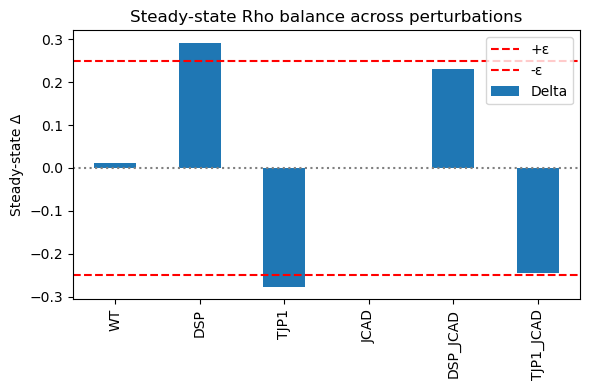

In [358]:

fig, ax = plt.subplots(figsize=(6,4))

delta_ss["Delta"].plot(kind="bar", ax=ax)

ax.axhline(eps, linestyle="--", label="+ε", color='red')
ax.axhline(-eps, linestyle="--", label="-ε", color='red')
ax.axhline(0, linestyle=":", color='grey')

ax.set_ylabel("Steady-state Δ")
ax.set_title("Steady-state Rho balance across perturbations")
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(summary_dir, f"ss_delta_bar.png"), dpi=300)

plt.close(fig)


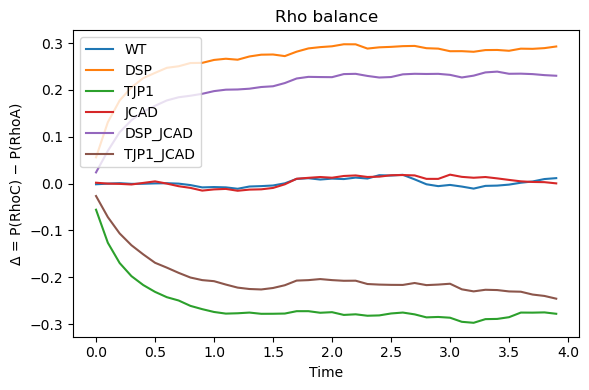

In [359]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(balance_df, label=balance_df.columns)

ax.set_title("Rho balance")
ax.set_xlabel("Time")
ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(summary_dir, f"delta_line.png"), dpi=300)

plt.close(fig)



,Phenotype,Delta
WT,Normal,0.011695
DSP,Hyper,0.292778
TJP1,Failed,-0.277898
JCAD,Normal,0.000523
DSP_TJP1,Normal,NaN
DSP_JCAD,Normal,0.230295
TJP1_JCAD,Normal,-0.245663
DSP_TJP1_JCAD,Normal,NaN


# Exploratory

In [195]:
# DSP single KO
m = model.copy()
m.mutate("DSP", "OFF")

# DSP + JCAD double KO
m2 = model.copy()
m2.mutate("DSP", "OFF")
m2.mutate("JCAD", "OFF")

# JCAD single KO
m3 = model.copy()
m3.mutate("JCAD", "OFF")

# TJP1 single KO
m4 = model.copy()
m4.mutate("TJP1", "OFF")


# TJP1 + JCAD double KO
m5 = model.copy()
m5.mutate("TJP1", "OFF")
m5.mutate("JCAD", "OFF")

In [241]:
res = m4.run()
prob = res.get_nodes_probtraj()
nodes_df = prob.copy()
nodes_df["delta"] = nodes_df["RhoC"] - nodes_df["RhoA"]
nodes_df.rename_axis('t').reset_index(inplace=True)
# nodes_df_final = nodes_df.iloc[-1]
# nodes_df_final
nodes_df


,DSP,TJP1,JCAD,RhoA,RhoC,delta
0.0,0.499899,0.0,0.500000,0.538238,0.482505,-0.055733
0.1,0.499900,0.0,0.500000,0.583756,0.457491,-0.126265
0.2,0.499901,0.0,0.500001,0.608714,0.439185,-0.169529
0.3,0.499901,0.0,0.500000,0.622491,0.424974,-0.197517
0.4,0.499901,0.0,0.500001,0.634360,0.417816,-0.216544
0.5,0.499900,0.0,0.500000,0.642071,0.410941,-0.231130
0.6,0.499900,0.0,0.500001,0.646705,0.404215,-0.242490
0.7,0.499900,0.0,0.500001,0.651849,0.402296,-0.249553
0.8,0.499899,0.0,0.500000,0.658413,0.397383,-0.261030
0.9,0.499899,0.0,0.500000,0.664383,0.396348,-0.268035


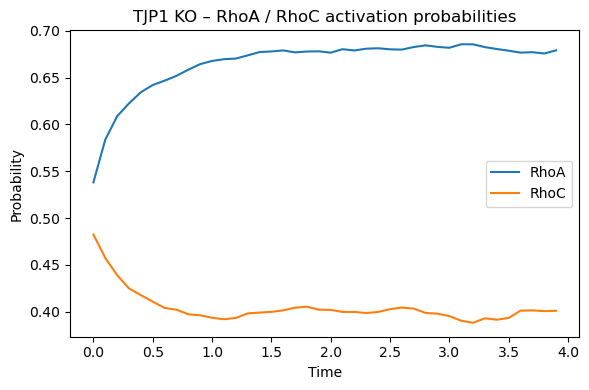

In [311]:
fig, ax = plt.subplots(figsize=(6,4))

nodes_df["RhoA"].plot(ax=ax, label="RhoA")
nodes_df["RhoC"].plot(ax=ax, label="RhoC")

ax.set_title("TJP1 KO – RhoA / RhoC activation probabilities")
ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.legend()

plt.tight_layout()
plt.show()


/var/folders/6g/q6rvxn7j5zz8mmsx5fy77vj80000gn/T/ipykernel_49861/502176354.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


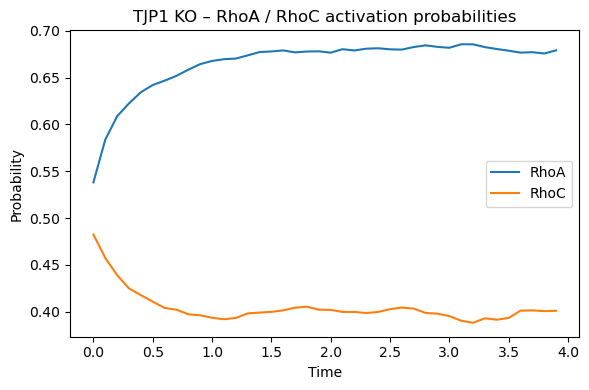

In [337]:
fig = plot_rhos('TJP1 KO', nodes_df)
fig.show()

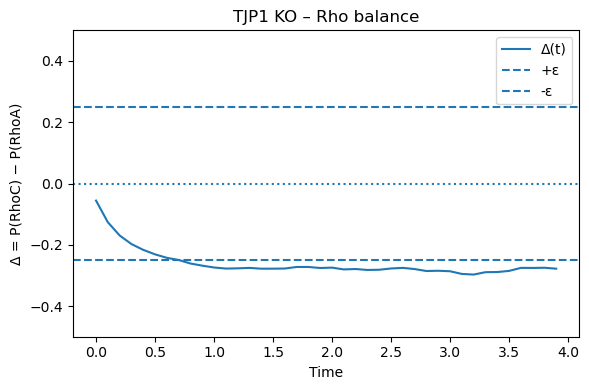

In [299]:

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(nodes_df.index, nodes_df["delta"], label="Δ(t)")

ax.axhline(eps, linestyle="--", label="+ε")
ax.axhline(-eps, linestyle="--", label="-ε")
ax.axhline(0, linestyle=":")

ax.set_ylim(-0.5, 0.5)
ax.set_title("TJP1 KO – Rho balance")
ax.set_xlabel("Time")
ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
A = nodes_df["RhoA"]
C = nodes_df["RhoC"]
delta = C - A
eps = 0.25

# Binary classification
hyper_bin   = (delta > eps).astype(float)
failed_bin  = (delta < -eps).astype(float)
normal_bin  = ((abs(delta) <= eps)).astype(float)

pheno_df = pd.DataFrame({
        "Failed": failed_bin,
        "Hyper": hyper_bin,
        "Normal": normal_bin
}, index=nodes_df.index)
pheno_df

## Threshold (eps) Method

Pros:

Very clear biological interpretation: hyper only when RhoC is significantly higher than RhoA.

Works well to capture knockout phenotypes in line with biology.

Easy to adjust eps for sensitivity.

Cons:

Binary: no information on magnitude of dominance, loses fine probabilistic detail.

Requires choosing eps, which may need calibration.

Use case: Best for categorical phenotypes where you want clear assignment (e.g., WT = Normal, DSP KO = Hyper).

In [122]:
delta = nodes_df["delta"]

eps = 0.3
hyper   = (delta > eps).astype(float)  # RhoC significantly higher than RhoA
failed  = (delta < -eps).astype(float) # RhoA significantly higher than RhoC
normal  = ((abs(delta) <= eps)).astype(float)

pd.DataFrame({
        "Failed": failed,
        "Hyper": hyper,
        "Normal": normal
}, index=nodes_df.index)

,Failed,Hyper,Normal
0.0,0.0,0.0,1.0
0.1,0.0,0.0,1.0
0.2,0.0,0.0,1.0
0.3,0.0,0.0,1.0
0.4,0.0,0.0,1.0
0.5,0.0,0.0,1.0
0.6,0.0,0.0,1.0
0.7,0.0,1.0,0.0
0.8,0.0,1.0,0.0
0.9,0.0,1.0,0.0


## Fractional Dominance Method

Pros:

Probabilistic, continuous, captures the relative contributions of RhoA vs RhoC.

Works well if both nodes have low-level fluctuations — gives smooth phenotypes.

Automatically bounded [0,1].

Cons:

Small numbers can cause numerical instability (division by tiny sums).

Doesn’t explicitly threshold what “dominance” means; even tiny differences contribute to hyper/failed.

Use case: Good for time-course or probabilistic weighting, not strict binary phenotype.

In [123]:
A = nodes_df["RhoA"]
C = nodes_df["RhoC"]
delta = C - A

hyper = (C / (A + C)).clip(0, 1)
failed  = (A / (A + C)).clip(0, 1)
normal  = 1 - hyper - failed

pd.DataFrame({
        "Failed": failed,
        "Hyper": hyper,
        "Normal": normal
}, index=nodes_df.index).tail()

,Failed,Hyper,Normal
3.5,0.227395,0.772605,8.326673e-17
3.6,0.226936,0.773064,5.551115e-17
3.7,0.226157,0.773843,0.000000e+00
3.8,0.225420,0.774580,-5.551115e-17
3.9,0.223817,0.776183,-2.775558e-17


## Combined

In [ ]:
# # Probabilistic weighting
# total = A + C + 1e-9
# hyper_prob = (C / total) * hyper_bin
# failed_prob = (A / total) * failed_bin
# normal_prob = normal_bin

# prob_df = pd.DataFrame({
#         "Failed": failed_prob,
#         "Hyper": hyper_prob,
#         "Normal": normal_prob
# }, index=nodes_df.index)
# prob_df

,Failed,Hyper,Normal
0.0,0.0,0.0,1.0
0.1,0.0,0.0,1.0
0.2,0.0,0.0,1.0
0.3,0.0,0.0,1.0
0.4,0.0,0.0,1.0
0.5,0.0,0.0,1.0
0.6,0.0,0.0,1.0
0.7,0.0,0.0,1.0
0.8,0.0,0.0,1.0
0.9,0.0,0.0,1.0


,<nil>,DSP,DSP -- JCAD,DSP -- JCAD -- RhoA,DSP -- JCAD -- RhoC,DSP -- JCAD -- RhoC -- RhoA,DSP -- RhoA,DSP -- RhoC,DSP -- RhoC -- RhoA,DSP -- TJP1,DSP -- TJP1 -- JCAD,DSP -- TJP1 -- JCAD -- RhoA,DSP -- TJP1 -- JCAD -- RhoC,DSP -- TJP1 -- JCAD -- RhoC -- RhoA,DSP -- TJP1 -- RhoA,DSP -- TJP1 -- RhoC,DSP -- TJP1 -- RhoC -- RhoA,JCAD,JCAD -- RhoA,JCAD -- RhoC,JCAD -- RhoC -- RhoA,RhoA,RhoC,RhoC -- RhoA,TJP1,TJP1 -- JCAD,TJP1 -- JCAD -- RhoA,TJP1 -- JCAD -- RhoC,TJP1 -- JCAD -- RhoC -- RhoA,TJP1 -- RhoA,TJP1 -- RhoC,TJP1 -- RhoC -- RhoA
3.5,0.015748,0.010566,0.003547,0.076915,0.007949,0.035789,0.057341,0.029609,0.028283,0.008223,0.000547,0.018417,0.016649,0.088286,0.040519,0.038080,0.039177,0.016038,0.044895,0.042696,0.022171,0.040312,0.046365,0.021775,0.009556,0.002701,0.006588,0.080228,0.036583,0.028633,0.057131,0.028680
3.6,0.016334,0.010582,0.003719,0.075788,0.007012,0.037681,0.056003,0.029707,0.029508,0.007844,0.000628,0.018177,0.016590,0.088505,0.041081,0.038128,0.038947,0.017337,0.043710,0.042151,0.022603,0.039761,0.045997,0.022108,0.010111,0.002996,0.007182,0.079251,0.036672,0.027501,0.056989,0.029399
3.7,0.016711,0.011085,0.003507,0.075189,0.008114,0.037390,0.054686,0.029954,0.030075,0.007724,0.000793,0.017767,0.018216,0.087125,0.041310,0.038761,0.038206,0.017664,0.042047,0.042262,0.023827,0.039640,0.045774,0.022076,0.009733,0.002501,0.006581,0.078919,0.038099,0.026443,0.056717,0.031107
3.8,0.017092,0.011847,0.003260,0.074747,0.008472,0.037721,0.053410,0.030590,0.029953,0.007926,0.000453,0.018703,0.018669,0.086074,0.039925,0.037804,0.040345,0.018064,0.041677,0.041883,0.024175,0.039848,0.045931,0.021328,0.009334,0.002804,0.006050,0.078208,0.039038,0.026388,0.056622,0.031655
3.9,0.015938,0.012523,0.003193,0.073853,0.007851,0.039303,0.052699,0.030652,0.029926,0.007959,0.000987,0.018854,0.017821,0.086239,0.040534,0.037674,0.039833,0.018074,0.041522,0.041244,0.024960,0.041130,0.046427,0.020706,0.009580,0.002600,0.005667,0.078623,0.039210,0.026349,0.056722,0.031348
